### TPC1 MCE 2023-24

As autoridades receberam uma chamada anónima a denunciar o Sr. Tomasino como o autor do assassínio do Sr. Jáeras, que teria ocorrido à mais de 15 anos. A alegada vítima foi cremada, pelo que já não é possível fazer uma autópsia. Na altura da morte do Sr. Jáeras pensou-se que tinha sofrido um acidente (talvez uma queda) que teria provocado danos cerebrais. Por razões que ficaram por apurar, os resultados da tomografia feita no hospital perderam-se. Uma busca aos arquivos apenas revelou um sinograma, mas que tinha sido feito por um estagiário, que por inexperiência tinha calibrado mal a máquina, do que resultou um sinal com demasiado ruído em cada projecção. Não se sabe também porque não foi feita autópsia. 

O Sr. Tomasino era uma pessoa influente, e hoje ainda o é mais. Como tal é possível que o seu sucesso seja a causa de muitas invejas, em particular dos seus opositores. Mas também há quem diga que não olha a meios para obter os seus objectivos, e que na altura desta morte o Sr. Tomasino estava envolvido em negócios escuros. Verdade? Maledicência?

Como a chamada foi anónima a polícia não pode fazer uma acusação sem quaisquer indícios. Nem sequer podem provar que houve alguma infração ou crime.

Será que os conseguimos ajudar? Foi-nos disponibilizado o sinograma que existe. Se tivesse sido bem construído, uma das nossas rotinas de retro-projecção faria isso facilmente. Mas no estado em que está, não se percebe quase nada. Uma possibilidade é usar os nossos conhecimentos de espectros e tentar retirar o ruído, fazendo depois a retro-projecção.

Deixo-vos abaixo o dito sinograma. Dele poderão extraír o número de varrimentos e o número de pixeis do detector. O ruído é de banda limitada, e como é devido ao feixe de varrimento, ocorreu em cada projecção isoladamente (não foi contaminação que ocorreu depois sobre todo o sinograma).

O nosso objectivo é saber se o Sr. Jáeras poderá ter morrido de causas não-naturais.






In [53]:
# Importar as bibliotecas que vamos usar
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from PIL import Image
from typing import Callable

a) Deverá começar por determinar as dimensões do array de detecção e quantos varrimentos foram feitos.

Conseguimos importar a imagem, notando que esta vem codificada com 3 canais de cor mais um canal de transparência (canal alpha). Como tal, comparamos os vários canais, notando que a diferença entre os canais de cor é nula, pelo que usamos apenas um deles para representar o sinograma.

PNG (235, 369) RGBA


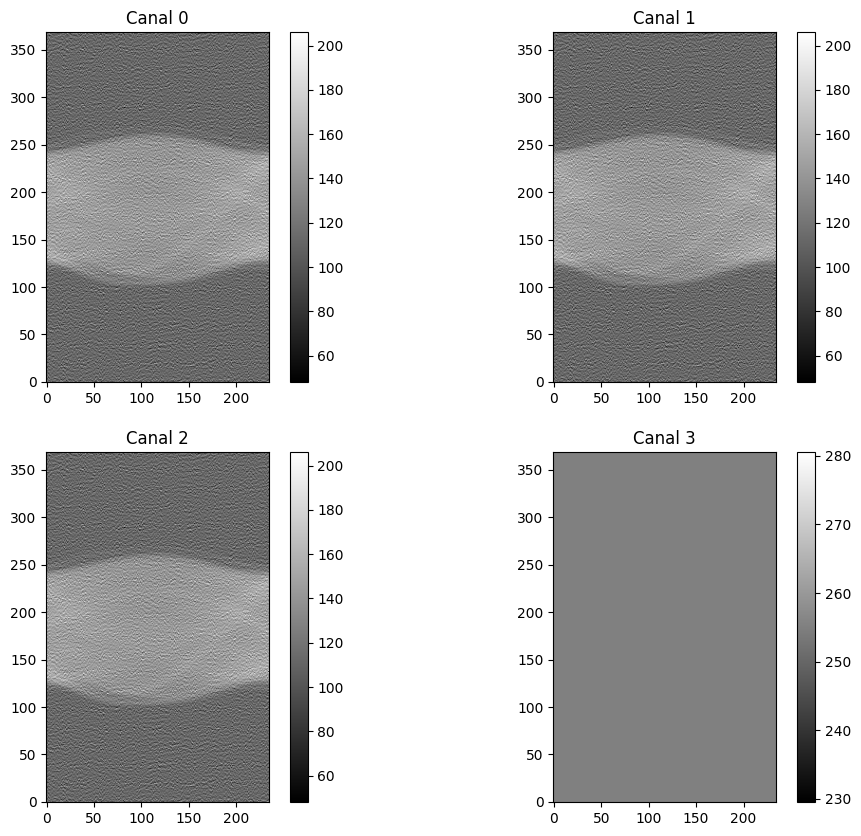

A diferença máxima entre os canais de cor é 0


In [54]:
# Carregar a imagem
sinograma = Image.open("grayscale_image.png")

# Propriedades da imagem
print(sinograma.format, sinograma.size, sinograma.mode)

# Transformar em array
pp = np.array(sinograma)

# Ver os canais
plt.figure(figsize=(12, 10))
for i in range(4):
    # Ver a imagem
    plt.subplot(2, 2, i+1)
    plt.title(f"Canal {i}")
    plt.imshow(pp[:, :, i], cmap="gray", origin="lower")
    plt.colorbar()
plt.show()

# Determinar diferença máxima entre canais de cor
print("A diferença máxima entre os canais de cor é " + str(np.max([
    np.max(np.abs(pp[:, :, 0] - pp[:, :, 1])),
    np.max(np.abs(pp[:, :, 0] - pp[:, :, 2])),
    np.max(np.abs(pp[:, :, 1] - pp[:, :, 2])),
])))

pp = pp[:, :, 0]


# Tamanho da imagem e número de projeções feitas
Nimg = pp.shape[0]
Npro = pp.shape[1]

pp = pp.T

b) Pode usar as rotinas que escreveu nas aulas PL para fazer a retroprojecção. Eu não consegui ver nada nas imagens, pois tinham muito ruído.

Como tal procure remover o ruído do sinograma.

Vamos começar por fazer a retroprojeção não filtrada, para avaliar o seu resultado.

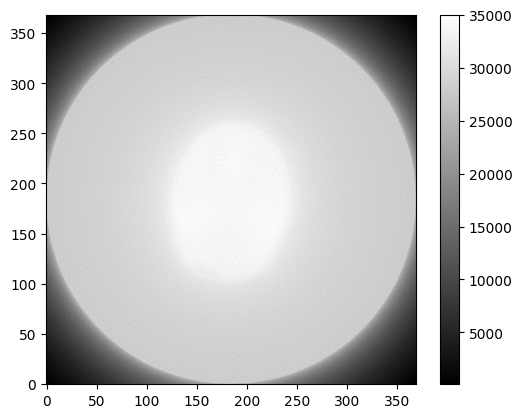

In [55]:
def radonRetro(Nimg: int, sinogram: np.ndarray, order=3) -> np.ndarray:
    """
        Dado o tamanho da imagem `Nimg` e o seu sinograma `sinogram` devolve a sua retroprojeção, selecionando apenas a secção central da imagem de dimensão `Nimg` por `Nimg`.
    """

    # Tamanho da imagem com o contentor
    N = sinogram.shape[1]

    # Array para a imagem
    img = np.zeros((N, N))

    # Ângulos usados
    projs = sinogram.shape[0]
    aa = np.linspace(0, 180, projs+1)[:-1]

    # Ir rodando a imagem e ir somando as linhas do sinograma a todas as suas colunas
    for index, angle in enumerate(aa[:-1]):
        # Linha do sinograma
        pp = sinogram[index]

        # Projetar a linha do sinograma ao longo da imagem
        imgProj = pp * np.ones((N, N))

        # Rodar a projeção de volta para a posição normal
        imgProj = sp.ndimage.rotate(imgProj, -angle, reshape=False, order=order)

        # Somar a projeção ao array inicial
        img += imgProj
    
    margin = (N-Nimg) // 2
    return img[margin:N-margin, margin:N-margin]


# Retroprojeção
rr = radonRetro(Nimg, pp)

# Ver a imagem
plt.imshow(rr, cmap="gray", origin="lower")
plt.colorbar()
plt.show()

Vamos ainda fazer a retroprojeção filtrada, uma vez que pode permitir ver uma melhor imagem.

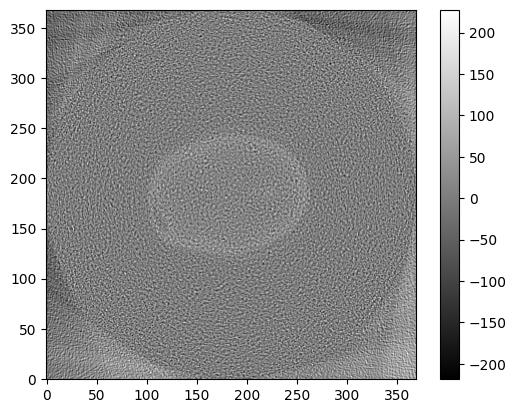

In [56]:
def radonRetroInterpolFiltrada(Nimg: int, sinogram: np.ndarray, order=3) -> np.ndarray:
    """
        Dado o tamanho da imagem `Nimg` e o seu sinograma `sinogram` devolve a sua retroprojeção, selecionando apenas a secção central da imagem de dimensão `Nimg` por `Nimg`.

        Esta versão usa interpolação pelos valores do sinograma para calcular o integral da retroprojeção.
    """

    # Tamanho da imagem com o contentor
    N = sinogram.shape[1]
    
    # Array para a imagem
    img = np.zeros((Nimg, Nimg))
    margin = (N-Nimg) // 2

    # Ângulos usados
    projs = sinogram.shape[0]
    aa = np.linspace(0, 180, projs+1)[:-1]
    ha = aa[1] - aa[0]

    # Transformada de Fourier do sinograma (feita na variável s)
    sFourier = np.fft.fft(sinogram, axis=1)

    # Aplicar o filtro
    # filtroRL = np.array([i for i in range(N//2)] + [i for i in range(N//2-1, -2, -1)])
    filtroRL = np.abs(np.fft.fftfreq(N)) # Filtro de Ram-Lak
    sFourier *= filtroRL

    # Fazer a transformada de Fourier inversa
    sinogram = np.real(np.fft.ifft(sFourier, axis=1))
    
    # Interpolação do sinograma lembrando que o centro da imagem está em N//2
    mid = N//2
    ppi = sp.interpolate.RectBivariateSpline(aa, np.arange(-mid, mid+1), sinogram)

    # Cálculos prévios
    cosaa = np.cos(np.radians(aa))
    sinaa = np.sin(np.radians(aa))

    # Fazer a retroprojeção
    for x in range(margin, Nimg+margin):
        for y in range(margin, Nimg+margin):
            # Valor de s, lembrando que (x, y) = (N//2, N//2) implica s = 0
            ss = (x - mid) * cosaa + (y - mid) * sinaa
            ff = np.array(ppi.ev(aa, ss))

            # Avaliar o integral com a regra de Simpson
            img[x-margin, y-margin] = ha * np.sum(ff[:-2:2] + 4 * ff[1:-1:2] + ff[2: :2]) / 3
    
    return img



# Retroprojeção
rrif = radonRetroInterpolFiltrada(Nimg, pp)

# Ver a imagem
plt.imshow(rrif, cmap="gray", origin="lower")
plt.colorbar()
plt.show()

De facto percebemos que o sinograma é o de um cérebro, mas não conseguimos obter nenhum detalhe sobre o seu interior.

Vamos então analisar o espetro de cada uma das linhas do sinograma.

Notamos que há uma banda limitada de frequências para as quais os coeficientes de Fourier do sinal estão claramente acima dos coeficientes circundantes.

Podemos então eliminar essas frequências do sinograma, uma vez que devem ser apenas ruído. Determinamos os índices para os quais há ruído por inspeção dos vários arrays onde estão guardadas as linhas.

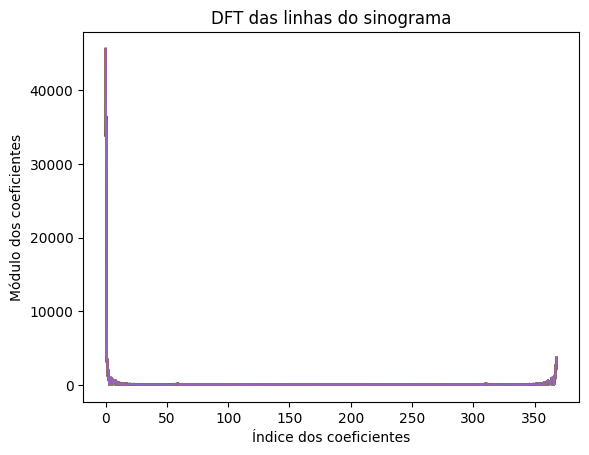

In [68]:
# Ver o espetro
plt.title("DFT das linhas do sinograma")
for index, line in enumerate(pp):
    # Espetro
    fftpp = np.fft.fft(line)

    # Representar graficamente
    plt.plot(np.abs(fftpp))

    # Eliminar o ruído
    fftpp[60:310] = 0

    # Reconstruir a linha sem o ruído
    line = np.real(np.fft.ifft(fftpp))

    # Guardar o resultado
    pp[index] = line

plt.xlabel("Índice dos coeficientes")
plt.ylabel("Módulo dos coeficientes")
plt.show()

c) Uma vez removido o ruído, pode agora fazer a retroprojecção, de modo a averiguar se se passou algo de anormal com o Sr. Jáeras. 

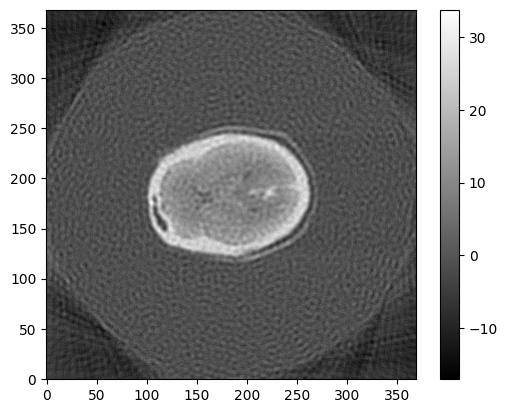

In [69]:
# Retroprojeção
rrif = radonRetroInterpolFiltrada(Nimg, pp)

# Ver a imagem
plt.imshow(rrif, cmap="gray", origin="lower")
plt.colorbar()
plt.show()

Verificamos de imediato que a qualidade da imagem melhorou significativamente, permitindo não só identificar o cérebro mas também alguns dos detalhes do seu interior.

Vamos fazer zoom na zona do cérebro, de forma a realçar os detalhes, e representar a imagem com um dos outros mapas de cor disponíveis.

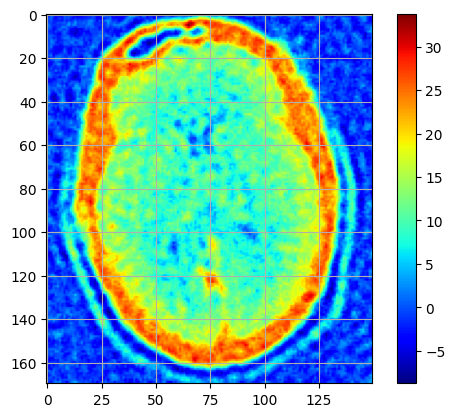

In [75]:
# Ver a imagem
plt.imshow(rrif[110:260, 100:270].T, cmap="jet", origin="upper")
plt.grid()
plt.colorbar()
plt.show()

Podemos comparar a imagem obtida com a de outros scans a cérebros disponíveis na internet, por exemplo [aqui](https://www.radiologymasterclass.co.uk/gallery/ct_brain/ct_brain_stacks/ventricles_ct_brain). Verificamos que em geral as imagens se assemelham.

A possível anomalia encontrada está próxima da posição (75, 120) na Figura acima. Esse ponto tem também absorção alta, tal como a fronteira do crânio. 

Continuando a pesquisa, vemos que [nesta outra fonte](https://www.medmastery.com/guides/brain-ct-clinical-guide/five-key-anatomical-features-identify-brain-computed-tomography-ct-0) a zona do cérebro em questão deveria ter uma atenuação baixa!

Como tal, é provável que a morte não tenha sido de causas naturais, pelo que a polícia deve investigar o caso.